# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)




**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [3]:
from ema_workbench import (Model, RealParameter, ScalarOutcome)

from dps_lake_model import lake_model

model = Model('lakeproblem', function=lake_model)

#specify uncertainties
model.uncertainties = [RealParameter('b', 0.1, 0.45),
                       RealParameter('q', 2.0, 4.5),
                       RealParameter('mean', 0.01, 0.05),
                       RealParameter('stdev', 0.001, 0.005),
                       RealParameter('delta', 0.93, 0.99)]

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
# note how we need to explicitely indicate the direction
model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE)]




In [7]:
from ema_workbench import ema_logging, MultiprocessingEvaluator
from ema_workbench import Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=8) as evaluator:
    results = evaluator.perform_experiments(scenarios=500,
                                            policies=4,
                                            uncertainty_sampling=Samplers.MC)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
100%|██████████████████████████████████████| 2000/2000 [01:06<00:00, 30.12it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


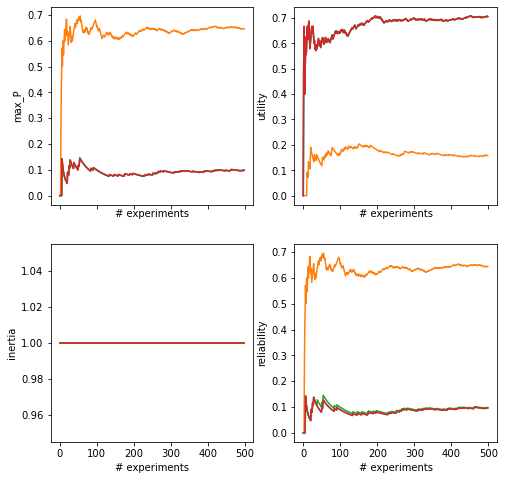

In [8]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]

robustness_funcs = {"max_P": maxp,
                    "utility": utility,
                    "inertia": inertia,
                    "reliability": reliability}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
        # data.shape should be (500,), given n_scenarios=500
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)



what we are analysing here is how our estimate of robustness converges to the `true` robustness value as a function of the number of experiments used to calculate it. This is most notable for utility, where we can also see the different for the different policies. Judging on the basis of these plots, we would need at least 200, but probably closer to 500 scenarios to reliably estimate our robustness. 

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [9]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 50
scenarios = sample_uncertainties(model, n_scenarios)


In [10]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [ScalarOutcome('fraction max_p', kind=MAXIMIZE, 
                             variable_name='max_P', function=maxp),
                       ScalarOutcome('fraction reliability', kind=MAXIMIZE, 
                             variable_name='reliability', function=reliability),
                       ScalarOutcome('fraction inertia', kind=MAXIMIZE, 
                             variable_name='inertia', function=inertia),
                       ScalarOutcome('fraction utility', kind=MAXIMIZE, 
                             variable_name='utility', function=utility)]

In [11]:
from ema_workbench import (MultiprocessingEvaluator, ema_logging, 
                           perform_experiments, SequentialEvaluator)
from ema_workbench.em_framework.optimization import (HyperVolume, 
                                                     EpsilonProgress)
from ema_workbench.em_framework.evaluators import BaseEvaluator

ema_logging.log_to_stderr(ema_logging.INFO)

convergence = [HyperVolume(minimum=[0,0,0,0], maximum=[1, 1, 1, 1]),
               EpsilonProgress()]
nfe = int(1e4)

# I work on a 12 core machine, so for most of you the value of
# n_processes is to high
with MultiprocessingEvaluator(model, n_processes=10) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, 
                                               nfe=nfe, convergence=convergence,
                                               epsilons=[0.05,]*len(robustnes_functions))

[MainProcess/INFO] pool started with 10 workers
  2%|▋                                   | 200/10000 [02:03<1:40:47,  1.62it/s]

**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

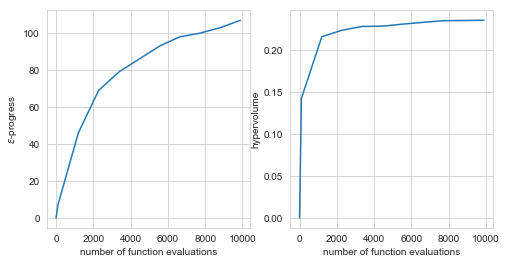

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


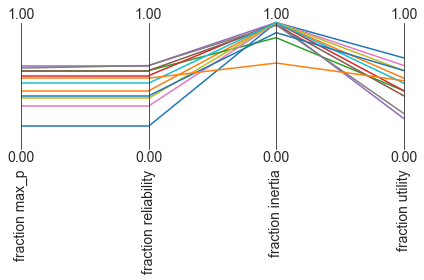

In [ ]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [ ]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

NameError: name 'archive' is not defined

In [ ]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] terminating pool


NameError: name 'policies_to_evaluate' is not defined

In [ ]:
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,inertia,max_P,reliability,utility
moro 0,1.000,0.146,0.147,0.693
moro 1,1.000,0.451,0.453,0.487
moro 10,0.893,0.411,0.414,0.573
moro 11,0.589,0.508,0.513,0.459
moro 2,0.890,0.629,0.634,0.344
moro 3,0.991,0.578,0.580,0.385
moro 4,0.999,0.662,0.663,0.238
moro 5,0.990,0.625,0.629,0.331
moro 6,0.997,0.340,0.344,0.619
moro 7,0.995,0.661,0.662,0.249


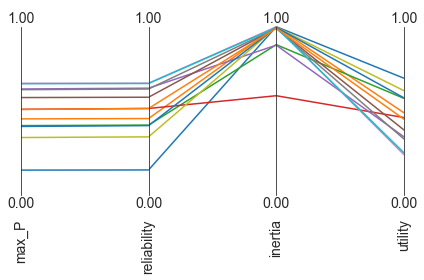

In [ ]:

# we pass the column labels explicitly to ensure the same order
# as in the previous plot
data = overall_robustness.loc[:, 
                              ['max_P', 'reliability', 'inertia', 'utility']]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

Interestingly, the pattern of scores is actually quite similar. We optimized over 50 scenarios, while the re-evaluation used 500 scenarios. 

Based on the first figures you made in this assignment, this might be surprising. The main reason why this is has to do with the difference in space filling properties of latin hypercube sampling versus monte carlo sampling



## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?